# Multiclass segmentation with the Lovász-Softmax
## Tensorflow version, see PyTorch version for more details & use in training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [29]:
import tensorflow as tf

In [4]:
import lovasz_losses_tf as L

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
from utils import paletteVOC, pil_grid, dummy_triangles

In [6]:
def pil(array):
    im = Image.fromarray(array)
    im.putpalette(paletteVOC(PIL=True))
    return im

In [7]:
import utils

In [8]:
from tfutils import define_scope

## Batch of 2 random images with classes [0, 1, 2] and void (255)

### Labels

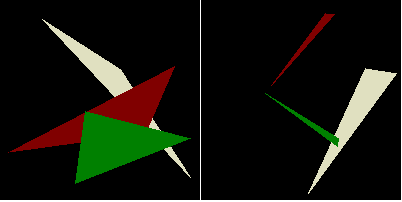

In [9]:
np.random.seed(18)
IGNORE = 255
C = 3
B = 2
H = 200
labels_ = [dummy_triangles(H, [0, 255, 1, 2]) for b in range(B)]
labels = np.stack(map(np.array, labels_)).astype(np.uint8)
pil_grid(labels_, 5, margin=1)

### Features

In [10]:
np.random.seed(57)
B, H, W = labels.shape
labels_ = labels.copy()
labels_[labels_ == 255] = np.random.randint(C, size=labels_.shape)[labels_ == 255] # random feats for void
labels_1hot = np.zeros((B, C, H, W))
for (b, h, w), c in np.ndenumerate(labels_):
    labels_1hot[b, c, h, w] = 1

In [11]:
feats = labels_1hot.copy()
feats += np.random.normal(0, 2, size=feats.shape)

## Model

### PyTorch reference

In [12]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
import lovasz_losses as L_pytorch

class ModelPytorch(nn.Module):
    def __init__(self):
        super(ModelPytorch, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, padding=1)
        
    def forward(self, x):
        return x + self.conv(x)

m_torch = ModelPytorch().cuda()
out = m_torch(Variable(torch.from_numpy(feats.astype(np.float32)).cuda()))
out = F.softmax(out)
loss_torch = L_pytorch.lovasz_softmax(out, torch.from_numpy(labels).cuda(),
                                      only_present=True, ignore=IGNORE, per_image=False)

In [13]:
with utils.printoptions(precision=4, suppress=True):
    print(out[0, 0, :10, :10].data.cpu().numpy())

[[0.495  0.6616 0.8209 0.138  0.9412 0.0517 0.1195 0.9726 0.7687 0.7769]
 [0.6458 0.7542 0.9901 0.2312 0.4403 0.0593 0.9528 0.9939 0.7504 0.8553]
 [0.9961 0.7906 0.0007 0.6817 0.0233 0.9945 0.9582 0.1661 0.9465 0.8669]
 [0.0603 0.9602 0.9792 0.3759 0.0361 0.9461 0.0004 0.1873 0.9617 0.9785]
 [0.6787 0.0901 0.5494 0.3695 0.9959 0.6317 0.9219 0.0598 0.0909 0.1624]
 [0.2111 0.2135 0.9884 0.9396 0.6757 0.5782 0.0157 0.5401 0.7308 0.9968]
 [0.4538 0.457  0.9072 0.3081 0.2607 0.9254 0.0302 0.3627 0.9857 0.6029]
 [0.8178 0.8362 0.0046 0.6312 0.92   0.9856 0.4048 0.6525 0.9942 0.758 ]
 [0.8319 0.9684 0.0063 0.9922 0.9527 0.3182 0.8561 0.9476 0.9492 0.9087]
 [0.1324 0.0026 0.8731 0.1913 0.9651 0.3318 0.0455 0.1422 0.5801 0.8852]]


In [14]:
loss_torch.data.cpu().numpy()[0]

0.7382159

#### small gradient check

In [15]:
loss_torch.backward()

In [16]:
m_torch.conv.bias.grad.data.cpu().numpy()

array([-0.04580249,  0.02285928,  0.02294321], dtype=float32)

### Tensorflow model definition

In [17]:
class Model:
    '''
    Simple linear model
    '''
    
    def __init__(self, feats):
        self.feats = feats
        self.scores
        self.predict

    @define_scope
    def scores(self):
        x = self.feats
        # replicate pytorch initialization
        init_weight = m_torch.conv.weight.data.cpu().numpy().transpose((2, 3, 1, 0))
        init_bias = m_torch.conv.bias.data.cpu().numpy()
        out = tf.nn.conv2d(x, tf.Variable(init_weight), strides=[1, 1, 1, 1], padding="SAME")
        out = tf.nn.bias_add(out, tf.Variable(init_bias))
        return x + out
    
    @define_scope
    def probas(self):
        return tf.nn.softmax(self.scores, 3)
    
    @define_scope
    def predict(self):
        return tf.argmax(self.scores, 3)

In [18]:
sess = tf.InteractiveSession()

In [19]:
labels_tf = tf.placeholder(np.int64, shape=(None, H, W), name='labels')
feats_tf = tf.placeholder(np.float32, shape=(None, H, W, C), name='features')

feed_dict = {labels_tf: labels, 
             feats_tf: feats.transpose(0, 2, 3, 1)}

In [20]:
m = Model(feats_tf)

In [21]:
sess.run(tf.global_variables_initializer())

In [22]:
loss = L.lovasz_softmax(m.probas, labels_tf, only_present=True,
                        ignore=IGNORE, per_image=False)

In [23]:
m.probas.eval(feed_dict).shape

(2, 200, 200, 3)

In [24]:
with utils.printoptions(precision=4, suppress=True):
    print(m.probas.eval(feed_dict)[0, :10, :10, 0])

[[0.495  0.6616 0.8209 0.138  0.9412 0.0517 0.1195 0.9726 0.7687 0.7769]
 [0.6458 0.7542 0.9901 0.2312 0.4403 0.0593 0.9528 0.9939 0.7504 0.8553]
 [0.9961 0.7906 0.0007 0.6817 0.0233 0.9945 0.9582 0.1661 0.9465 0.8669]
 [0.0603 0.9602 0.9792 0.3759 0.0361 0.9461 0.0004 0.1873 0.9617 0.9785]
 [0.6787 0.0901 0.5494 0.3695 0.9959 0.6317 0.9219 0.0598 0.0909 0.1624]
 [0.2111 0.2135 0.9884 0.9396 0.6757 0.5782 0.0157 0.5401 0.7308 0.9968]
 [0.4538 0.457  0.9072 0.3081 0.2607 0.9254 0.0302 0.3627 0.9857 0.6029]
 [0.8178 0.8362 0.0046 0.6312 0.92   0.9856 0.4048 0.6525 0.9942 0.758 ]
 [0.8319 0.9684 0.0063 0.9922 0.9527 0.3182 0.8561 0.9476 0.9492 0.9087]
 [0.1324 0.0026 0.8731 0.1913 0.9651 0.3318 0.0455 0.1422 0.5801 0.8852]]


In [25]:
loss.eval(feed_dict)

0.73821586

#### Gradient w.r.t. bias

In [26]:
tf.trainable_variables()

[<tf.Variable 'scores/Variable:0' shape=(3, 3, 3, 3) dtype=float32_ref>,
 <tf.Variable 'scores/Variable_1:0' shape=(3,) dtype=float32_ref>]

In [28]:
tf.gradients(loss, tf.trainable_variables()[1])[0].eval(feed_dict)

array([-0.04580249,  0.02285928,  0.02294322], dtype=float32)